In [1]:
using VRPLIB, JuMP, Gurobi, Random, Distributions,LightGraphs, GraphPlot, MetaGraphs, GraphRecipes, Plots,Graphs


(process:22340): GLib-GIO-WARNING **: 10:08:16.427: Unexpectedly, UWP app `38526MediaLife.ZipPlus_2.0.4.0_x86__1crh1k73ty8mg' (AUMId `38526MediaLife.ZipPlus_1crh1k73ty8mg!ZipExtractor') supports 89 extensions but has no verbs


In [2]:
instance_P_n16_k8 = readTSP("D:/Documentos/PUC/Mestrado/2021.2/Optimization Under Uncertainty/project_definition/Vrp-Set-P/P/P-n16-k8.vrp")
instance_P_n19_k2 = readTSP("D:/Documentos/PUC/Mestrado/2021.2/Optimization Under Uncertainty/project_definition/Vrp-Set-P/P/P-n19-k2.vrp")
instance_P_n20_k2 = readTSP("D:/Documentos/PUC/Mestrado/2021.2/Optimization Under Uncertainty/project_definition/Vrp-Set-P/P/P-n20-k2.vrp")
instance_P_n21_k2 = readTSP("D:/Documentos/PUC/Mestrado/2021.2/Optimization Under Uncertainty/project_definition/Vrp-Set-P/P/P-n21-k2.vrp")
instance_P_n22_k2 = readTSP("D:/Documentos/PUC/Mestrado/2021.2/Optimization Under Uncertainty/project_definition/Vrp-Set-P/P/P-n22-k2.vrp")
instances = [instance_P_n16_k8,instance_P_n19_k2,instance_P_n20_k2,instance_P_n21_k2,instance_P_n22_k2]
instances_names = ["instance_P_n16_k8","instance_P_n19_k2","instance_P_n20_k2","instance_P_n21_k2","instance_P_n22_k2"]
instance_nodes = [collect(1:instances[i].dimension) for i in 1:length(instances)]
instance_numVehicles = [8,2,2,2,2]
capacity_upscaling = 1.1 #improvement in capacity for feasibility
scenarios = 5; # Num scenarios

## DETERMINISTIC FORMULATION

In [3]:
deterministic_routes_dict = Dict{Int64,Matrix}()
deterministic_u_dict = Dict{Int64,Vector}()
deterministic_obj_value_dict = Dict{Int64,Float64}()
iter = 1
for instance in instances
    println("=================== $(instances_names[iter]) ===================")
    nodes = instance_nodes[iter]
    K = instance_numVehicles[iter]
    
    model_deterministic = Model(Gurobi.Optimizer)
    # set_optimizer_attribute(model, "LogLevel",0)

    @variables(model_deterministic,
    begin
        x[nodes,nodes], Bin
        u[nodes[2:end]] ≥ 0
    end)

    @constraints(model_deterministic,
        begin
            ct1[j in nodes[2:end]], sum(x[i,j] for i in nodes) == 1
            ct2[i in nodes[2:end]], sum(x[i,j] for j in nodes) == 1
            ct3, sum(x[i,1] for i in nodes) == K
            ct4, sum(x[1,j] for j in nodes) == K
            ct5[i in nodes[2:end], j in nodes[2:end]; i != j], u[j] - u[i] + (instance.capacity*capacity_upscaling)*(1-x[i,j]) ≥ instance.demand[j]
            ct6[i in nodes[2:end]], instance.demand[i] ≤ u[i] ≤ (instance.capacity*capacity_upscaling)
            ct7[i in nodes], x[i,i] == 0
        end)

    @objective(model_deterministic, Min, sum(instance.weights[i,j] * x[i,j] for i in nodes for j in nodes))
    set_optimizer_attribute(model_deterministic, "TimeLimit", 60)
    set_optimizer_attribute(model_deterministic, "OutputFlag", 0)
    optimize!(model_deterministic)

    obj_value = objective_value(model_deterministic)
    println("Objective value: $(obj_value)")
    println("Termination status: $(termination_status(model_deterministic))")
    
    u_list = [value.(u)[CartesianIndex(i)] for i in 1:(instance.dimension-1)]
    x_matrix = zeros(Int64, instance.dimension, instance.dimension)
    for i in nodes
        for j in nodes
            x_matrix[i,j] = value.(x)[CartesianIndex(i,j)]
        end
    end
    push!(deterministic_routes_dict, iter => x_matrix)
    push!(deterministic_u_dict, iter => u_list)
    push!(deterministic_obj_value_dict, iter => obj_value)

#     for i in nodes
#         for j in nodes
#             if(value.(x)[CartesianIndex(i,j)]==1)
#                 println("x[$i,$j] = $(value.(x)[CartesianIndex(i,j)])")
#             end
#         end
#     end
    iter += 1
end

=================== instance_P_n16_k8 ===================
Academic license - for non-commercial use only - expires 2022-01-10
Objective value: 439.0
Termination status: OPTIMAL
=================== instance_P_n19_k2 ===================
Academic license - for non-commercial use only - expires 2022-01-10
Objective value: 195.0
Termination status: OPTIMAL
=================== instance_P_n20_k2 ===================
Academic license - for non-commercial use only - expires 2022-01-10
Objective value: 209.0
Termination status: OPTIMAL
=================== instance_P_n21_k2 ===================
Academic license - for non-commercial use only - expires 2022-01-10
Objective value: 211.0
Termination status: OPTIMAL
=================== instance_P_n22_k2 ===================
Academic license - for non-commercial use only - expires 2022-01-10
Objective value: 215.0
Termination status: OPTIMAL


## ROBUST FORMULATION

In [4]:
robust_routes_dict = Dict{Int64,Matrix}()
robust_u_dict = Dict{Int64,Vector}()
robust_obj_value_dict = Dict{Int64,Float64}()
iter = 1
for instance in instances
    nodes = instance_nodes[iter]
    K = instance_numVehicles[iter]
    # Generate Uniform Random demands
    seed = 8748748
    rng = MersenneTwister(seed)
    demand_variation_5_perc = rand(rng,Uniform(-0.13,0.13),instance.dimension,scenarios)
    demand_scenarios_5_perc =  ceil.(demand_variation_5_perc.*instance.demand); #[node,scenario]
    
    println("=================== $(instances_names[iter]) ===================")
    # Model
    model2 = Model(Gurobi.Optimizer)
    # set_optimizer_attribute(model, "LogLevel",0)

    @variables(model2,
    begin
        x[nodes,nodes], Bin
        u[nodes[2:end]] ≥ 0
    end)

    @constraints(model2,
        begin
            ct1[j in nodes[2:end]], sum(x[i,j] for i in nodes) == 1
            ct2[i in nodes[2:end]], sum(x[i,j] for j in nodes) == 1
            ct3, sum(x[i,1] for i in nodes) == K
            ct4, sum(x[1,j] for j in nodes) == K
            ct5[i in nodes[2:end], j in nodes[2:end]; i != j], u[j] - u[i] + (instance.capacity*capacity_upscaling)*(1-x[i,j]) ≥ instance.demand[j] + maximum([maximum(demand_scenarios_5_perc[j,:]),0])
            ct6[i in nodes[2:end]], 0 ≤ u[i] ≤ (instance.capacity*capacity_upscaling)
            ct7[i in nodes], x[i,i] == 0
        end)

    @objective(model2, Min, sum(instance.weights[i,j] * x[i,j] for i in nodes for j in nodes))
    set_optimizer_attribute(model2, "TimeLimit", 120)
    set_optimizer_attribute(model2, "OutputFlag", 0)
    optimize!(model2)
    obj_value = objective_value(model2)
    println("Objective value: $(obj_value)")
    println("Termination status: $(termination_status(model2))")
    
    u_list = [value.(u)[CartesianIndex(i)] for i in 1:(instance.dimension-1)]
    x_matrix = zeros(Int64, instance.dimension, instance.dimension)
    for i in nodes
        for j in nodes
            x_matrix[i,j] = round(value.(x)[CartesianIndex(i,j)])
        end
    end
    push!(robust_routes_dict, iter => x_matrix)
    push!(robust_u_dict, iter => u_list)
    push!(robust_obj_value_dict, iter => obj_value)
    # for i in nodes
    #     for j in nodes
    #         if(value.(x)[CartesianIndex(i,j)]==1)
    #             println("x[$i,$j] = $(value.(x)[CartesianIndex(i,j)])")
    #         end
    #     end
    # end
    iter += 1
end

=================== instance_P_n16_k8 ===================
Academic license - for non-commercial use only - expires 2022-01-10
Objective value: 460.0
Termination status: OPTIMAL
=================== instance_P_n19_k2 ===================
Academic license - for non-commercial use only - expires 2022-01-10
Objective value: 212.0
Termination status: OPTIMAL
=================== instance_P_n20_k2 ===================
Academic license - for non-commercial use only - expires 2022-01-10
Objective value: 221.0
Termination status: OPTIMAL
=================== instance_P_n21_k2 ===================
Academic license - for non-commercial use only - expires 2022-01-10
Objective value: 211.0
Termination status: OPTIMAL
=================== instance_P_n22_k2 ===================
Academic license - for non-commercial use only - expires 2022-01-10
Objective value: 221.0
Termination status: OPTIMAL


In [5]:
# # u_list = [value.(u)[CartesianIndex(i)] for i in 1:(instance.dimension-1)]
# iterator = 1
# for instance in instances
#     x_matrix_deterministic = deterministic_routes_dict[iterator]
#     x_matrix_robust = robust_routes_dict[iterator]
#     nodelabel = 1:instance.dimension
#     a = Graphs.SimpleGraphs.SimpleDiGraph(x_matrix_deterministic)
#     b = Graphs.SimpleGraphs.SimpleDiGraph(x_matrix_robust)
#     plot_a = gplot(a, nodelabel = nodelabel,nodefillc=colorant"royalblue2",
#         edgestrokec=colorant"gray20",edgelinewidth=0,arrowlengthfrac=0.05)
#     plot_b = gplot(b, nodelabel = nodelabel,nodefillc=colorant"royalblue2",
#         edgestrokec=colorant"gray20",edgelinewidth=0,arrowlengthfrac=0.05)
#     display(plot_a)
#     display(plot_b)
#     iterator += 1
# end

In [6]:
# Generate Normal Random demands
seed = 7656572
rng = MersenneTwister(seed)
atendimento_demanda_robust = Dict{Int64, Matrix}()
atendimento_demanda_deterministic = Dict{Int64, Matrix}()

it = 1
for instance in instances
    simulated_demand = ceil.(rand(rng,Normal(mean(instances[it].demand), std(instances[it].demand)),instances[it].dimension,1000))
    nodes = instance_nodes[it]
    atendimento_demanda_rob = ones(Int64, instance.dimension,1000)
    atendimento_demanda_det = ones(Int64, instance.dimension,1000)
    count_nao_atendeu = 0
    count_atendeu = 0
    for k in 1:1:1000
        for i in nodes[2:end]
            for j in nodes[2:end]
                if(i != j)
                    if(robust_u_dict[it][j-1] - robust_u_dict[it][i-1] + (instances[it].capacity*capacity_upscaling)*(1-robust_routes_dict[it][i,j]) < simulated_demand[j,k])
                        atendimento_demanda_rob[j,k] = 0
                    end
                    if(deterministic_u_dict[it][j-1] - deterministic_u_dict[it][i-1] + (instances[it].capacity*capacity_upscaling)*(1-deterministic_routes_dict[it][i,j]) < simulated_demand[j,k])
                        atendimento_demanda_det[j,k] = 0
                    end
                end
            end
        end
    end
    push!(atendimento_demanda_robust, it => atendimento_demanda_rob)
    push!(atendimento_demanda_deterministic, it => atendimento_demanda_det)
    it += 1
end

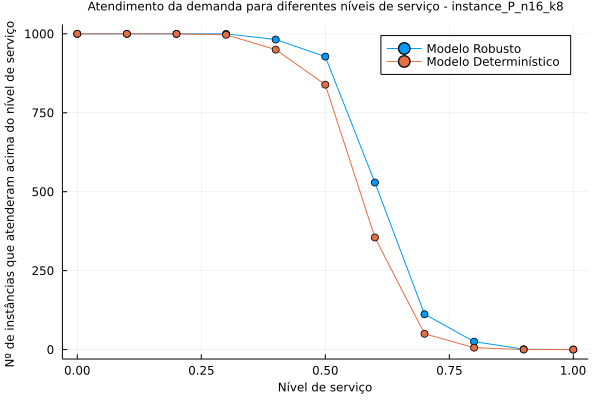

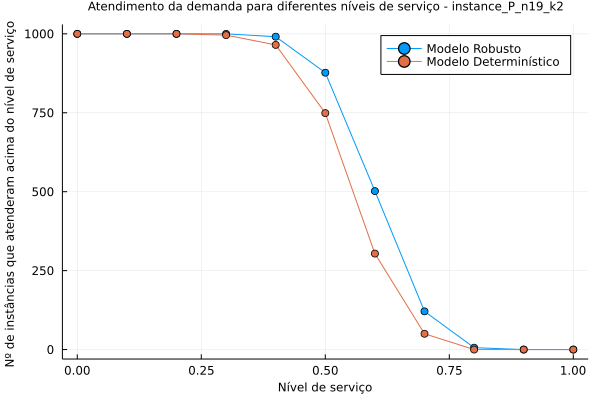

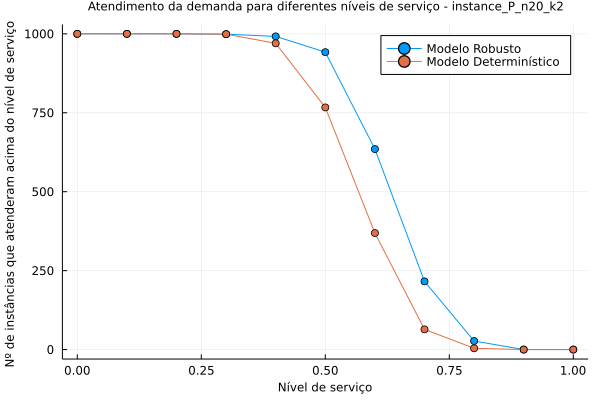

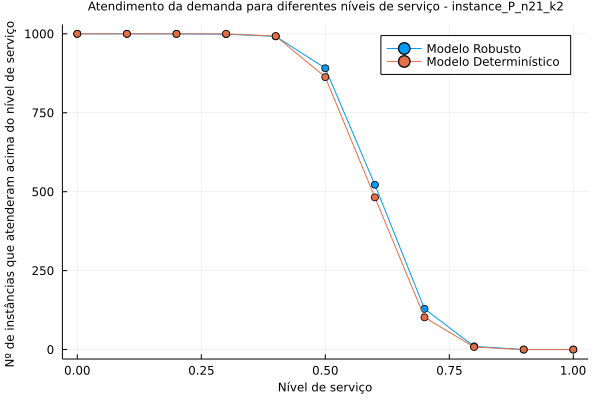

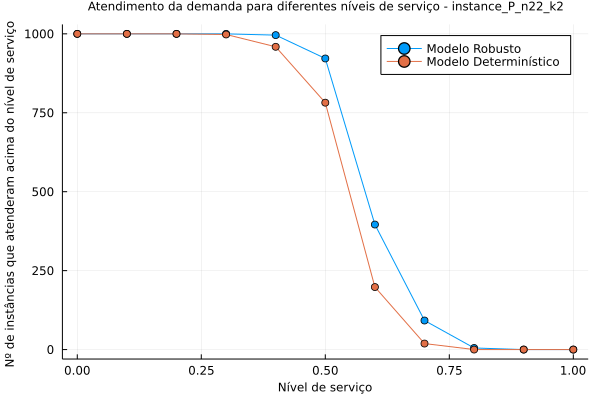

In [7]:
nserv_list = collect(0:0.1:1)
atend_nserv_robust = Dict{Float64,Int64}()
atend_nserv_det = Dict{Float64,Int64}()
for i in 1:length(atendimento_demanda_robust)
    for nserv in nserv_list 
        push!(atend_nserv_robust, nserv => count(>=(size(atendimento_demanda_robust[i],1)*nserv),vec(sum(atendimento_demanda_robust[i],dims=1))))
        push!(atend_nserv_det, nserv => count(>=(size(atendimento_demanda_deterministic[i],1)*nserv),vec(sum(atendimento_demanda_deterministic[i],dims=1))))
    end
    plt = plot(atend_nserv_robust,shape = :circle,
    title = "Atendimento da demanda para diferentes níveis de serviço - $(instances_names[i])",
    xlabel = "Nível de serviço", ylabel = "Nº de instâncias que atenderam acima do nível de serviço ",
    labels="Modelo Robusto", titlefontsize = 8, guidefontsize=8)
    plot!(atend_nserv_det,shape = :circle, labels="Modelo Determinístico")
    display(plt)
end
# Em quantas instancias simuladas o modelo conseguiu atender a demanda em pelo menos nserv% dos nós

In [8]:
# model = Model(GLPK.Optimizer)
# # set_optimizer_attribute(model, "LogLevel",0)

# @variables(model,
# begin
#     x[nodes,nodes,1:K], Bin
#     u[nodes[2:end]] ≥ 0
# end)

# @constraints(model,
#     begin
#         ct1[j in nodes[2:end], k in 1:K], sum(x[i,j,k] for i in nodes) == sum(x[j,i,k] for i in nodes)
#         ct2[j in nodes[2:end]], sum(x[i,j,k] for i in nodes for k in 1:K) == 1
#         ct3[k in 1:K], sum(x[1,j,k] for j in nodes[2:end]) == 1
#         ct4[k in 1:K], sum(demand[j]*x[i,j,k] for i in nodes for j in nodes[2:end]) ≤ C
#         ct5[k in 1:K,i in nodes[2:end], j in nodes[2:end]; i != j], u[j] - u[i] ≥ demand[j]- C*(1-x[i,j,k])
#         ct6[i in nodes[2:end]], demand[i] ≤ u[i] ≤ C
#         ct7[i in nodes, k in 1:K], x[i,i,k] == 0
#     end)

# @objective(model, Min, sum(instance.weights[i,j] * x[i,j,k] for i in nodes for j in nodes for k in 1:K))
# set_optimizer_attribute(model, "tm_lim", 3600*1_000)
# set_optimizer_attribute(model, "msg_lev", GLPK.GLP_MSG_ON)
# optimize!(model)
# objective_value(model)